# Recreate AdeMAMix Rosenbrock Plot from Paper

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/main/examples/contrib/rosenbrock_ademamix.ipynb)

This notebook attempts to recreate Figure 2 from the [AdeMAMix paper](https://arxiv.org/pdf/2409.03137)

## Imports

In [1]:
import matplotlib.pyplot as plt
import optax
import jax
import jax.numpy as jnp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

plt.rc("figure", figsize=(20, 10))
plt.rc("font", size=14)

In [2]:
from optax.schedules import linear_schedule
from optax._src import base


def cond_print(cond, fmt, *args):
    return jax.lax.cond(cond, lambda: (jax.debug.print(fmt, *args), 0)[1], lambda: 0)

## Functions

In [3]:
def rosenbrock(x):
    return jnp.square(1 - x[0]) + 100.0 * jnp.square(x[1] - jnp.square(x[0]))


# Create a grid of x and y values
x = jnp.linspace(-5, 10, 1000)
y = jnp.linspace(-5, 10, 1000)
X, Y = jnp.meshgrid(x, y)

# Compute the Rosenbrock function values for each point on the grid
Z = rosenbrock([X, Y])

In [4]:
num_iterations = 100000

## Generate Adam Trajectories (Baseline)

In [5]:
all_b1_params = []
for b1 in [0.9, 0.99, 0.999, 0.9999]:
    solver = optax.adam(learning_rate=0.003, b1=b1, b2=0.9999)
    params = jnp.array([-3.0, 5.0])
    print("Objective function: ", rosenbrock(params))
    opt_state = solver.init(params)

    def _body_fn(carry, _):
        params, opt_state, i = carry
        grad = jax.grad(rosenbrock)(params)
        updates, opt_state = solver.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        cond_print(
            i % 25000 == 0,
            "Objective function for b1={} at iteration {} = {}",
            b1,
            i,
            rosenbrock(params),
        )
        return (params, opt_state, i + 1), params

    _, all_params = jax.lax.scan(
        _body_fn, (params, opt_state, 0), length=num_iterations
    )
    all_b1_params.append(jnp.concatenate([params[None, ...], all_params], 0))
all_b1_params_array = jnp.array(all_b1_params)

Objective function:  1616.0
Objective function for b1=0.8999999761581421 at iteration 0 = 1599.225830078125
Objective function for b1=0.8999999761581421 at iteration 25000 = 8.61838436126709
Objective function for b1=0.8999999761581421 at iteration 50000 = 0.26170656085014343
Objective function for b1=0.8999999761581421 at iteration 75000 = 3.934304004360456e-06
Objective function:  1616.0
Objective function for b1=0.9900000095367432 at iteration 0 = 1599.225830078125
Objective function for b1=0.9900000095367432 at iteration 25000 = 8.37004280090332
Objective function for b1=0.9900000095367432 at iteration 50000 = 0.1776006668806076
Objective function for b1=0.9900000095367432 at iteration 75000 = 1.1652794000838185e-06
Objective function:  1616.0
Objective function for b1=0.9990000128746033 at iteration 0 = 1599.225830078125
Objective function for b1=0.9990000128746033 at iteration 25000 = 8.757574081420898
Objective function for b1=0.9990000128746033 at iteration 50000 = 1.4611389636

## Generate AdeMAMix Trajectories

### Create `alpha` scheduler

In [6]:
alpha = 0.8
alpha = linear_schedule(0, alpha, num_iterations)

### Create `b3` scheduler

In [7]:
def b3_scheduler(beta_end: float, beta_start: float = 0, warmup: int = 0):
    def f(beta):
        return jnp.log(0.5) / jnp.log(beta) - 1

    def f_inv(t):
        return jnp.power(0.5, 1 / (t + 1))

    def schedule(step):
        is_warmup = jnp.array(step < warmup).astype(jnp.float32)
        alpha = step / float(warmup)
        return is_warmup * f_inv(
            (1.0 - alpha) * f(beta_start) + alpha * f(beta_end)
        ) + beta_end * (1.0 - is_warmup)

    return schedule

In [8]:
all_ademamix_params = []
for b3 in [0.999, 0.9999]:
    b3 = b3_scheduler(b3, 0, num_iterations)
    solver = optax.contrib.ademamix(
        learning_rate=0.003, b1=0.99, b2=0.999, b3=b3, alpha=alpha
    )
    params = jnp.array([-3.0, 5.0])
    print("Objective function: ", rosenbrock(params))
    opt_state = solver.init(params)

    def _body_fn(carry, _):
        params, opt_state, i = carry
        grad = jax.grad(rosenbrock)(params)
        updates, opt_state = solver.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        cond_print(
            i % 25000 == 0,
            "Objective function for b3={} at iteration {} = {}",
            b3(i),
            i,
            rosenbrock(params),
        )
        return (params, opt_state, i + 1), params

    _, all_params = jax.lax.scan(
        _body_fn, (params, opt_state, 0), length=num_iterations
    )
    all_ademamix_params.append(jnp.concatenate([params[None, ...], all_params], 0))
all_ademamix_params_array = jnp.array(all_ademamix_params)

Objective function:  1616.0
Objective function for b3=0.0 at iteration 0 = 1599.227294921875
Objective function for b3=0.9960060715675354 at iteration 25000 = 1.1232594943066943e-07
Objective function for b3=0.9980010390281677 at iteration 50000 = 6.792194540139462e-08
Objective function for b3=0.9986668825149536 at iteration 75000 = 1.3234323148481053e-07
Objective function:  1616.0
Objective function for b3=0.0 at iteration 0 = 1599.227294921875
Objective function for b3=0.9995999932289124 at iteration 25000 = 5.958846571729737e-08
Objective function for b3=0.9997999668121338 at iteration 50000 = 1.4210854715202004e-14
Objective function for b3=0.9998666644096375 at iteration 75000 = 2.3673273119584337e-08


## Plot the Figure

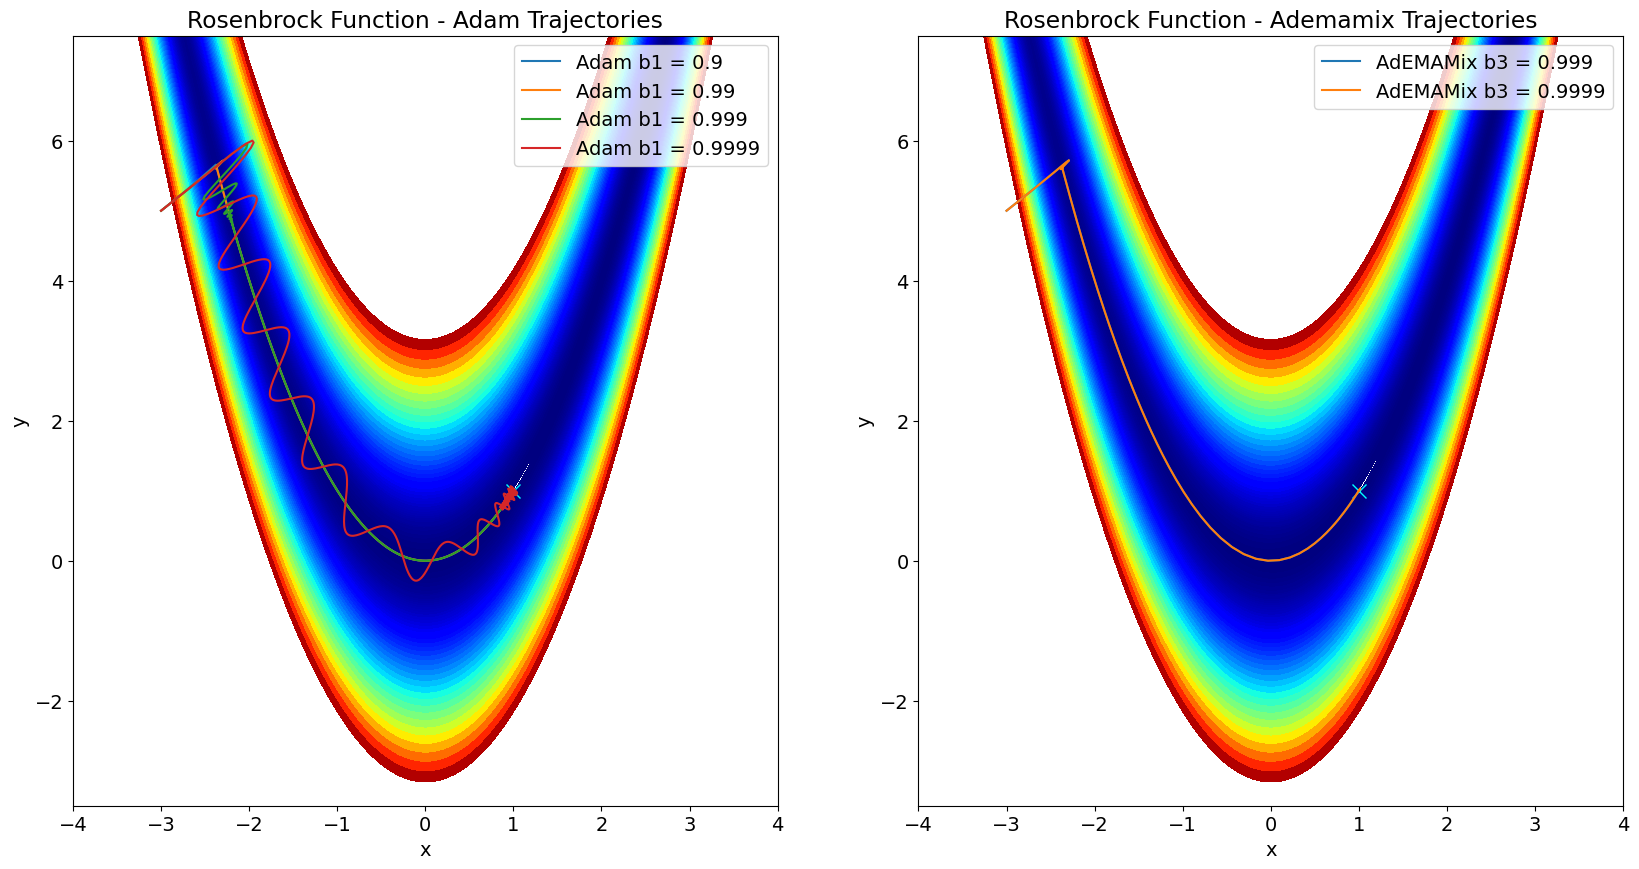

In [9]:
fig = plt.figure()
ax = fig.subplots(1, 2)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Rosenbrock Function - Adam Trajectories")
# Show the plot
ax[0].plot([1], [1], "x", mew=1, markersize=10, color="cyan")
ax[0].contourf(X, Y, Z, np.logspace(-1, 3, 100), cmap="jet")
for i, b1 in enumerate([0.9, 0.99, 0.999, 0.9999]):
    ax[0].plot(
        all_b1_params_array[i, ::100, 0],
        all_b1_params_array[i, ::100, 1],
        label=f"Adam b1 = {b1}",
    )
ax[0].set_xlim(-4, 4)
ax[0].set_ylim(-3.5, 7.5)
ax[0].legend()

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Rosenbrock Function - Ademamix Trajectories")
# Show the plot
ax[1].plot([1], [1], "x", mew=1, markersize=10, color="cyan")
ax[1].contourf(X, Y, Z, np.logspace(-1, 3, 100), cmap="jet")
for i, b3 in enumerate([0.999, 0.9999]):
    ax[1].plot(
        all_ademamix_params_array[i, ::100, 0],
        all_ademamix_params_array[i, ::100, 1],
        label=f"AdEMAMix b3 = {b3}",
    )
ax[1].set_xlim(-4, 4)
ax[1].set_ylim(-3.5, 7.5)
ax[1].legend()

plt.show()

## Plot Figure 2a from Paper

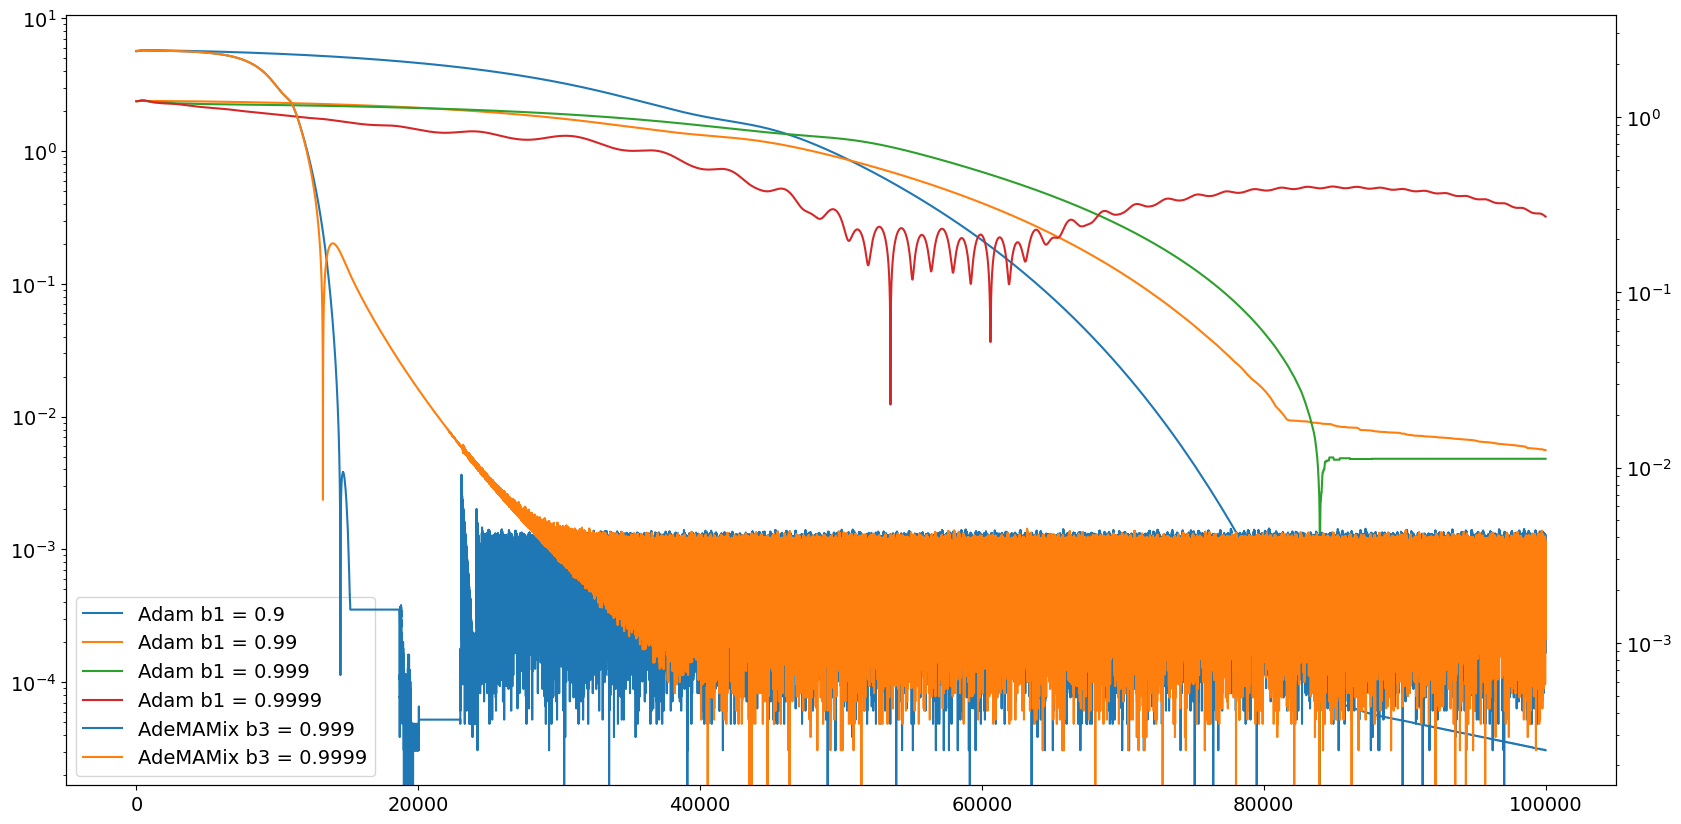

In [10]:
N = num_iterations + 1
fig, ax = plt.subplots()
lns = ax.semilogy(
    jnp.arange(N),
    jnp.linalg.norm(
        all_b1_params_array[0, :, :]
        - jnp.ones(
            2,
        ),
        axis=1,
    ),
    label="Adam b1 = 0.9",
)
for i, b1 in enumerate([0.99, 0.999, 0.9999]):
    lns += ax.semilogy(
        jnp.arange(N),
        jnp.sqrt(
            jnp.linalg.norm(
                all_b1_params_array[i + 1, :, :]
                - jnp.ones(
                    2,
                ),
                axis=1,
            )
        ),
        label=f"Adam b1 = {b1}",
    )
ax1 = ax.twinx()
for i, b3 in enumerate([0.999, 0.9999]):
    lns += ax1.semilogy(
        jnp.arange(N),
        jnp.sqrt(
            jnp.linalg.norm(
                all_ademamix_params_array[i, :, :]
                - jnp.ones(
                    2,
                ),
                axis=1,
            )
        ),
        label=f"AdeMAMix b3 = {b3}",
    )
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
plt.show()

## Print out final values

In [11]:
print("Adam Values:")
print(
    "Final value with b1 = 0.9:"
    f" ({float(all_b1_params_array[0,-1,0])},"
    f" {float(all_b1_params_array[0,-1,1])})"
)
print(
    "Final value with b1 = 0.99:"
    f" ({float(all_b1_params_array[1,-1,0])},"
    f" {float(all_b1_params_array[1,-1,1])})"
)
print(
    "Final value with b1 = 0.999:"
    f" ({float(all_b1_params_array[2,-1,0])},"
    f" {float(all_b1_params_array[2,-1,1])})"
)
print(
    "Final value with b1 = 0.9999:"
    f" ({float(all_b1_params_array[3,-1,0])},"
    f" {float(all_b1_params_array[3,-1,1])})"
)
print("AdeMAMix Values:")
print(
    "Final value with b3 = 0.999:"
    f" ({float(all_ademamix_params_array[0,-1,0])},"
    f" {float(all_ademamix_params_array[0,-1,1])})"
)
print(
    "Final value with b3 = 0.9999:"
    f" ({float(all_ademamix_params_array[1,-1,0])},"
    f" {float(all_ademamix_params_array[1,-1,1])})"
)

Adam Values:
Final value with b1 = 0.9: (0.9999862909317017, 0.9999725818634033)
Final value with b1 = 0.99: (0.9999859929084778, 0.9999719858169556)
Final value with b1 = 0.999: (1.000010371208191, 1.0000207424163818)
Final value with b1 = 0.9999: (0.9527074098587036, 0.9081478714942932)
AdeMAMix Values:
Final value with b3 = 0.999: (1.000002384185791, 0.9999974966049194)
Final value with b3 = 0.9999: (0.9999936819076538, 1.000006079673767)
